In [1]:
'''
clustering nypd precincts based on 911 calls reported ratio /
demographics data
'''

'\nclustering nypd precincts based on 911 calls reported ratio /\ndemographics data\n'

In [2]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import math
import shapely as shp
from geopandas import GeoDataFrame
from shapely.geometry import Point
from datetime import datetime
from fiona.crs import from_epsg
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import re
from pandas.tseries.holiday import get_calendar, HolidayCalendarFactory, GoodFriday
from datetime import datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as rs
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

from itertools import compress

np.random.seed(222)

%matplotlib inline
%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
### read in precinct level demographics data
data_folder = '/Users/geoffperrin/Desktop/CUSP/GRA/NYPD/data/'
precinct_df = pd.read_csv(data_folder + '170420_pp_pop.csv')
precinct_df.rename(columns={'number_of_': 'number_of_911_calls', 'incident_c': 'incident_count'}, inplace=True)
precinct_df['calls_per_incident'] = precinct_df.number_of_911_calls / precinct_df.incident_count
#replace NAs with zeros
precinct_df['calls_per_incident'].fillna(0, inplace=True)
precinct_df.head()

,Unnamed: 0,Precinct,Shape_Leng,Shape_Area,field_1,meanfemale,meanelderl,meanwhite_,meanblack_,meanasian_,meanhh,meanhh_chi,meanhh_liv,meanedu_hi,meannon_en,meanunempl,meanvacanc,meanmed_re,meanmed_in,meanmerrie,meanlonger,ratio_com,ratio_res,ratio_off,ratio_ret,ratio_gar,ratio_strg,ratio_fac,meandiv_ar,sumFreq,sumbars,called_911,number_of_911_calls,incident_count,ratio_call,graffiti_c,public_sch,calls_per_inc,public_housing_count,sumpop,calls_per_inc_per_capita,calls_per_incident
0,1,1,79979.38927,4.718213e+07,1,0.49825,0.07057,0.74474,0.03290,0.15403,245.66000,0.43539,0.44691,0.76004,0.04720,0.02906,0.17206,1988.02041,121795.57447,0.42592,0.14559,0.36046,0.29212,0.18941,0.04615,0.00960,0.02441,0.00128,0.61482,210,84,3,90,3,1.00000,358,19,30.00000,50,86629,0.000346,30.000000
1,2,5,18676.12426,1.808880e+07,2,0.48870,0.11206,0.37708,0.05230,0.47612,144.87719,0.25946,0.42496,0.43872,0.27302,0.04568,0.10332,1131.08772,61132.83673,0.37576,0.21970,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.66470,130,40,2,6,4,0.50000,1550,10,1.50000,57,81286,0.000018,1.500000
2,3,6,27182.61011,2.213193e+07,3,0.49669,0.09824,0.83960,0.02427,0.08845,108.34375,0.38256,0.56843,0.77366,0.02175,0.03493,0.13495,2035.27869,113879.00000,0.32694,0.12712,0.24529,0.51035,0.09272,0.06752,0.02762,0.01078,0.00135,0.55937,385,112,0,0,3,0.00000,247,6,0.00000,64,80342,0.000000,0.000000
3,4,7,17301.47578,1.836339e+07,4,0.51967,0.14202,0.37639,0.09229,0.34302,178.68750,0.18567,0.44041,0.36402,0.26427,0.04915,0.06115,924.21739,39742.32558,0.38028,0.28104,0.21227,0.57893,0.01635,0.04601,0.02086,0.00748,0.00162,0.46920,197,52,4,42,7,0.57143,834,24,6.00000,48,65552,0.000092,6.000000
4,5,9,19773.40187,2.139401e+07,5,0.51897,0.07346,0.63156,0.07417,0.15358,135.56716,0.20519,0.50965,0.59596,0.09805,0.04524,0.08975,1519.44615,72633.66129,0.27291,0.24511,0.21355,0.57351,0.04600,0.06289,0.01275,0.00675,0.00034,0.52823,424,143,8,135,14,0.57143,786,18,9.64286,67,105388,0.000091,9.642857


### build random forest to determine best features(?)

In [4]:
cols = list(precinct_df.iloc[:,5:30]) + list(precinct_df.iloc[:,35:37])+ ['public_housing_count']

In [5]:
y = precinct_df.calls_per_incident
X = precinct_df[cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.0, random_state = 123)

In [6]:
r_tree = RFR()
param_grid = {'max_depth': [3, 5, 7, 9], 'n_estimators': np.arange(1,502,100)}
r_tree_tuned = GridSearchCV(r_tree, param_grid)
#r_tree_optimum = RFC(r_tree_tuned.best_estimator_)
r_tree_tuned.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  1, 101, 201, 301, 401, 501]), 'max_depth': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [7]:
feature_importance = r_tree_tuned.best_estimator_.fit(X_train, y_train).feature_importances_

In [24]:
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df = Feature_importance_df.sort_values(by="importance", ascending=False)
Feature_importance_df

,variables,importance
25,graffiti_c,0.15662
3,meanblack_,0.0993183
13,meanmed_in,0.0983947
10,meanunempl,0.0978836
16,ratio_com,0.0903805
4,meanasian_,0.0710562
18,ratio_off,0.0546128
14,meanmerrie,0.0502644
15,meanlonger,0.0499056
1,meanelderl,0.033775


In [25]:
important_features = Feature_importance_df['variables'].head(7).tolist()
all_vars = ['Precinct'] + important_features

In [26]:
all_vars

['Precinct',
 'graffiti_c',
 'meanblack_',
 'meanmed_in',
 'meanunempl',
 'ratio_com',
 'meanasian_',
 'ratio_off']

In [27]:
precinct_df_sel_feat = precinct_df[all_vars]
precinct_df_sel_feat.head()

,Precinct,graffiti_c,meanblack_,meanmed_in,meanunempl,ratio_com,meanasian_,ratio_off
0,1,358,0.03290,121795.57447,0.02906,0.36046,0.15403,0.18941
1,5,1550,0.05230,61132.83673,0.04568,0.00000,0.47612,0.00000
2,6,247,0.02427,113879.00000,0.03493,0.24529,0.08845,0.09272
3,7,834,0.09229,39742.32558,0.04915,0.21227,0.34302,0.01635
4,9,786,0.07417,72633.66129,0.04524,0.21355,0.15358,0.04600


In [28]:
#need to standardize each column so that each value is a z score
for i in important_features:
    print i
    for j in range(len(precinct_df_sel_feat)):
        precinct_df_sel_feat[i][j] = (precinct_df_sel_feat[i][j] - precinct_df_sel_feat[i].mean())\
        / precinct_df_sel_feat[i].std()

graffiti_c


/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


meanblack_
meanmed_in
meanunempl
ratio_com
meanasian_
ratio_off


In [29]:
precinct_df_sel_feat.head()

,Precinct,graffiti_c,meanblack_,meanmed_in,meanunempl,ratio_com,meanasian_,ratio_off
0,1,0,-0.891883,2.239114,-1.559030,2.669327,0.308526,4.223318
1,5,2,-0.671975,0.051809,0.031020,-0.450263,3.100102,-0.162579
2,6,0,-0.693744,1.973891,-0.025850,0.362645,-0.187910,0.035012
3,7,0,-0.403004,-0.635098,0.054939,0.251515,0.533365,-0.122356
4,9,0,-0.430199,0.548697,0.033493,0.253840,-0.002004,-0.056848


In [30]:
X = precinct_df[important_features]
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.660982058987
For n_clusters =3, the average silhouette_score is :0.545842528093
For n_clusters =4, the average silhouette_score is :0.547340744299
For n_clusters =5, the average silhouette_score is :0.545824311745
For n_clusters =6, the average silhouette_score is :0.536702572509
For n_clusters =7, the average silhouette_score is :0.548361961284
For n_clusters =8, the average silhouette_score is :0.594461552807


In [31]:
n = 6 # number of clusters
dd = precinct_df[important_features] #data
#train the model.
km=KMeans(random_state=324,n_clusters=n)
res=km.fit(dd)
#result.
print(res.labels_)
# print res.predict(dd)

[3 2 3 0 1 4 4 4 3 4 3 3 3 0 4 5 2 0 0 5 0 0 5 5 5 0 5 2 5 0 5 0 2 5 0 2 0
 1 0 0 2 2 0 0 2 5 0 4 0 4 0 0 0 1 1 0 1 0 0 2 2 2 1 2 1 2 2 0 1 1 2 0 0 2
 1 1 1]


In [16]:
precinct_df_sel_feat['cluster_label'] = res.predict(dd)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
precinct_df_sel_feat.head()

,Precinct,meanfemale,meanelderl,meanwhite_,meanblack_,meanasian_,meanhh,meanhh_chi,cluster_label
0,1,-1.186701,-0.687823,1.180075,-0.891883,0.308526,0.225501,1.756205,1
1,5,-0.062780,0.352813,-0.320582,-0.671975,3.100102,-1.100700,-0.057922,0
2,6,0.013825,0.161069,1.426865,-0.693744,-0.187910,-1.488784,0.570937,4
3,7,0.150472,0.598572,-0.281272,-0.403004,0.533365,-0.550069,-0.407716,0
4,9,0.167011,-0.138384,0.599979,-0.430199,-0.002004,-1.004851,-0.257609,0


In [18]:
### read in precinct shapefile
### read in census block GROUP shapefile
ny_precinct_raw = gp.read_file(data_folder + 'nypp_17a/nypp.shp')
ny_precinct_raw = ny_precinct_raw.to_crs(epsg=4326)
ny_precinct_raw.head()

,Precinct,Shape_Area,Shape_Leng,geometry
0,1,4.718213e+07,79979.389271,(POLYGON ((-74.04387761573953 40.6901876764099...
1,5,1.808880e+07,18676.124259,POLYGON ((-73.98863862848766 40.72293372029702...
2,6,2.213193e+07,27182.610113,POLYGON ((-73.99968392160721 40.73855224869309...
3,7,1.836339e+07,17301.475777,"POLYGON ((-73.9734532411957 40.71896288711555,..."
4,9,2.139401e+07,19773.401872,POLYGON ((-73.97160900246389 40.72672340120322...


In [19]:
ny_precinct_cluster = ny_precinct_raw.merge(precinct_df_sel_feat)

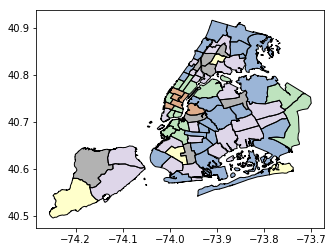

In [20]:
ny_precinct_cluster.plot(column='cluster_label', cmap='Accent')